# Setup Environment

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
!pip install --upgrade --force-reinstall --no-deps kaggle

# set kaggle json dir
import os
#Personal example
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle/plant-pathology/input1/.kaggle/"
os.environ['KAGGLE_USERNAME'] = "spregler"
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

     |████████████████████████████████| 61kB 4.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=b9c2343698fba6e2a87f02eff4de5e2fd7e15cd1de557c6b45b939fc34d36c5a
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [0]:
from google.colab import drive

In [0]:
%cd Drive


[Errno 2] No such file or directory: 'Drive'
/content/Drive/Drive


In [0]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

 99% 769M/779M [00:13<00:00, 54.2MB/s]
100% 779M/779M [00:13<00:00, 58.9MB/s]


In [0]:
!unzip plant-pathology-2020-fgvc7

In [0]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 23kB/s 
     |████████████████████████████████| 4.0MB 56.6MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


# Import Dependencies & Extract Data

In [0]:
import os 
from pathlib import Path

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import fastai
import fastai.vision
from fastai import *
from fastai.vision import *
from fastai.vision import learner

import pandas as pd
import numpy as np

root_dir = Path("/content/Drive/Drive/") # Local path object in colab
train_df = pd.read_csv('/content/Drive/Drive/train.csv')
test_df = pd.read_csv("/content/Drive/Drive/test.csv")
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


# Transform Data w/ Helper Function

In [0]:
def transformPipeline(df):
  # Creates a class column and assign it to the index which produces the max value for each row
  df['class'] = np.argmax(train_df.loc[:, ['healthy','multiple_diseases','rust','scab']].values, axis=1)
  # Drops columnns that are no longer of use
  df.drop(columns=['healthy','multiple_diseases','rust','scab'], inplace=True)
  print("Transformed df: ")
  print(train_df.head())


In [0]:
transformPipeline(train_df)

Transformed df: 
  image_id  class
0  Train_0      3
1  Train_1      1
2  Train_2      0
3  Train_3      2
4  Train_4      0


# Create ImageList Object Using DataBlocks API

In [0]:
np.random.seed(42)
src = (ImageList.from_df(train_df, root_dir, folder='images', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df())

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05)

data = (src.transform(tfms, size=224)
      .databunch()
      .normalize(imagenet_stats))

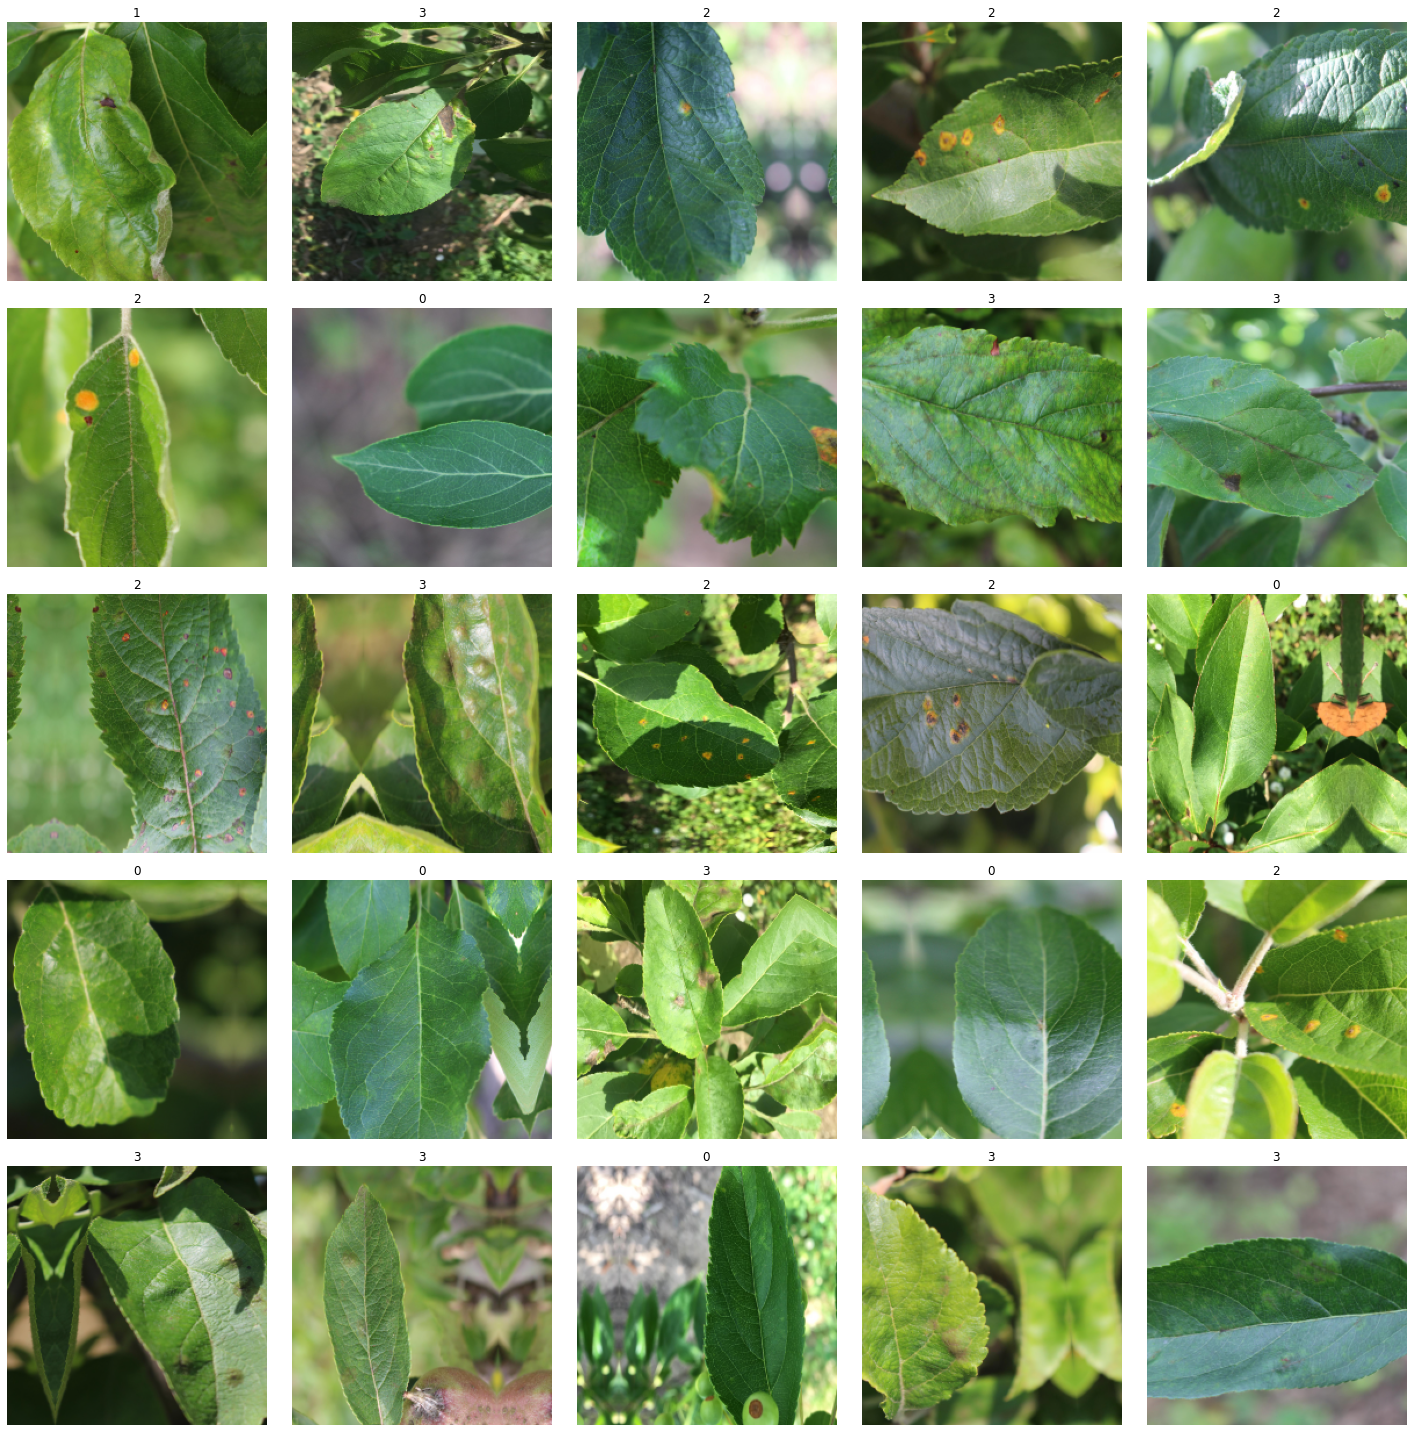

In [0]:
data.show_batch()

# ResNet50

In [0]:
arch = models.resnet50
# import resnet50
learner = cnn_learner(data, arch, metrics=[accuracy , error_rate], wd=1e-1).to_fp32()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
learner.fit_one_cycle(4,1e-3) # fit to out data

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.284538,0.493114,0.848901,0.151099,02:11
1,0.872780,0.373433,0.898352,0.101648,02:09
2,0.634401,0.333768,0.909341,0.090659,02:09
3,0.511459,0.325304,0.903846,0.096154,02:08


In [0]:
learner.save('resnet50-FP32-0') # save model

In [0]:
learner.load('resnet50-FP32-0') # load model

In [0]:
learner.unfreeze() # unfreeze for tuning

In [0]:
learner.lr_find() # find optimal lr

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


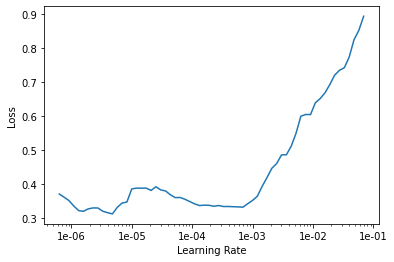

In [0]:
learner.recorder.plot() 

In [0]:
learner.fit_one_cycle(10, slice(3e-4, 1e-3)) # choose a lr before the loss begins to increase 1e-04 - 1e-03 will do nicely

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.378372,0.346388,0.920330,0.079670,02:11
1,0.342901,0.517856,0.873626,0.126374,02:11
2,0.412683,0.435519,0.925824,0.074176,02:11
3,0.369029,0.227245,0.931319,0.068681,02:10
4,0.317370,0.160605,0.947802,0.052198,02:12
5,0.273762,0.225499,0.942308,0.057692,02:12
6,0.240577,0.164472,0.950549,0.049451,02:11
7,0.202778,0.127674,0.967033,0.032967,02:11
8,0.166369,0.119416,0.969780,0.030220,02:11
9,0.133025,0.114969,0.975275,0.024725,02:11


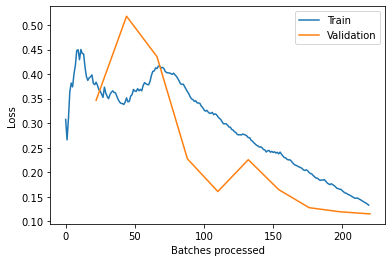

In [0]:
learner.recorder.plot_losses()

In [0]:
learner.save('resnet50-FP32-final')

# Kaggle Competition Stuff

In [0]:
preds, y = learn.get_preds(DatasetType.Test) 

In [0]:
sample_df = pd.read_csv(root_dir/'sample_submission.csv')
sample_df.iloc[:,1:] = preds.numpy()
sample_df.to_csv('submission.csv', index=False)

In [0]:
import pickle 
learner.export() # Save model for inference to export.pkl

# Conclusion:
The end model was able to acheive a score of .922 on the kaggle challenge learderboard: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/leaderboard

Just by tuning a ResNet50, we were able to acheive an accuracy of 0.975.

The origninal paper outlining this challenge can be found: https://arxiv.org/abs/2004.11958